In [42]:
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer
from leia import SentimentIntensityAnalyzer
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import unicodedata
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from PortugueseLemmatizer import PortugueseMess
import seaborn as sns

nltk.download('vader_lexicon')
nltk.download('rslp')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
dados = pd.read_csv("./MGLU3.csv")

In [25]:

def combinar_paragrafos(texto_lista):
    texto = ' '.join(texto_lista.strip("[]").replace("'", "").split(", "))
    texto = texto.lower()
    return texto

def remove_stop_words(texto):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    retorno = []
    for p in texto:
        if p not in stopwords:
            retorno.append(p)
    return retorno

def remove_pontuacao(texto):
    retorno = []
    for token in texto:
        token = re.sub(r'[^a-zA-Z0-9\s]', '', token)
        token = unicodedata.normalize('NFD', token).encode('ascii', 'ignore').decode('utf-8')
        retorno.append(token)
    retorno = list(filter(None, retorno))
    return retorno

def analisar_sentimento(texto):
    analisador = SentimentIntensityAnalyzer()
    
    if type(texto) == list:
        texto = " ".join(texto)
    return analisador.polarity_scores(texto)['compound'] 

def tokenizacao_lemmatizer(texto):
    tokens = word_tokenize(texto)
    palavras_lemmatizadas = [PortugueseMess(w) for w in tokens]
    return palavras_lemmatizadas

def retornar_sentimento(sentimento):
    if sentimento >= 0.05:
        return 'positivo'
    elif sentimento <= -0.05:
        return 'negativo'
    else:
        return 'neutro'

In [26]:
pd.options.display.max_colwidth = 50

dados['texto'] = dados['texto'].apply(combinar_paragrafos)
dados['sent_proc_cru'] = dados['texto'].apply(analisar_sentimento)

dados['proc_1'] = dados['texto'].apply(tokenizacao_lemmatizer)
dados['proc_2'] = dados['proc_1'].apply(remove_stop_words)
dados['proc_3'] = dados['proc_2'].apply(remove_pontuacao)
dados['sent_proc_3'] = dados['proc_3'].apply(analisar_sentimento)

dados['sent_cru_texto'] = dados['sent_proc_cru'].apply(retornar_sentimento)
dados['sent_proc_3_texto'] = dados['sent_proc_3'].apply(retornar_sentimento)
dados['texto'].head()

0    por paula arend laier são paulo (reuters) - o ...
1    em dia de apetite por ativos brasileiros que c...
2    por marcela ayres brasília (reuters) - o gover...
3    por camila moreira e rodrigo viga gaier são pa...
4    investing.com – ações de companhias varejistas...
Name: texto, dtype: object

In [27]:
def plotar_analise(df, coluna):
    negativos = 0
    neutros = 0
    positivos = 0

    for analise in df[coluna]:
        if analise == 'positivo':
            positivos += 1
        elif analise == 'negativo':
            negativos += 1
        else:
            neutros += 1

    sentimentos = ['Negativo', 'Neutro', 'Positivo']
    quantidades = [negativos, neutros, positivos]

    for i, v in enumerate(quantidades):
        plt.text(sentimentos[i], v, str(v), ha='center', va='bottom')

    plt.bar(sentimentos, quantidades, color=['red', 'blue', 'green'])
    plt.xlabel('Sentimento')
    plt.ylabel('Quantidade')
    plt.title('Distribuição de Sentimentos')
    plt.show()

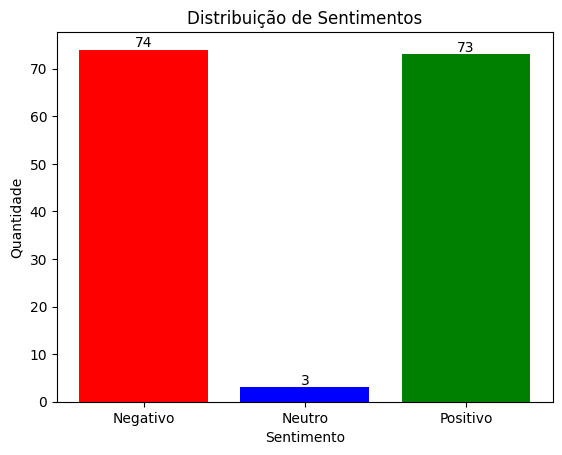

In [31]:
plotar_analise(dados, 'sent_cru_texto')

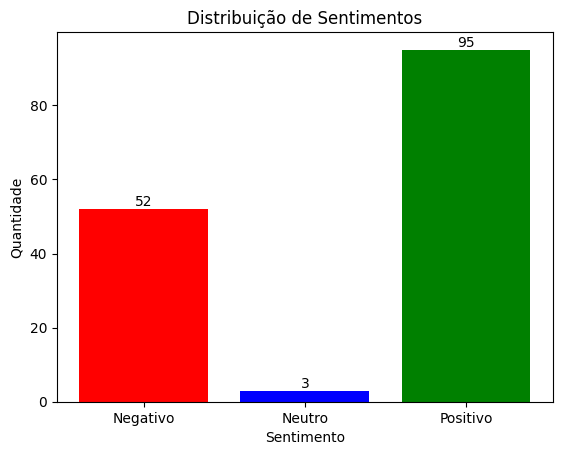

In [32]:
plotar_analise(dados, 'sent_proc_3_texto')

In [33]:
pd.options.display.max_colwidth = 150

print(dados[['url', 'sent_proc_3_texto']])

                                                                                                                                     url   
0                     https://br.investing.com/news/stock-market-news/ibovespa-dispara-mais-de-4-impulsionado-por-alivio-no-ipca-1102052  \
1       https://br.investing.com/news/stock-market-news/em-maior-alta-desde-outubro-ibovespa-sobe-429-e-retoma-os-106-mil-pontos-1102086   
2                https://br.investing.com/news/economy/governo-anuncia-fim-da-isencao-para-encomendas-internacionais-de-ate-us50-1102164   
3           https://br.investing.com/news/economic-indicators/varejo-no-brasil-inicia-ano-com-alta-recorde-nas-vendas-de-janeiro-1102251   
4       https://br.investing.com/news/stock-market-news/dados-do-varejo-e-taxacao-de-marketplaces-asiaticos-movem-acoes-do-setor-1102284   
..                                                                                                                                   ...   
145    https://br.in

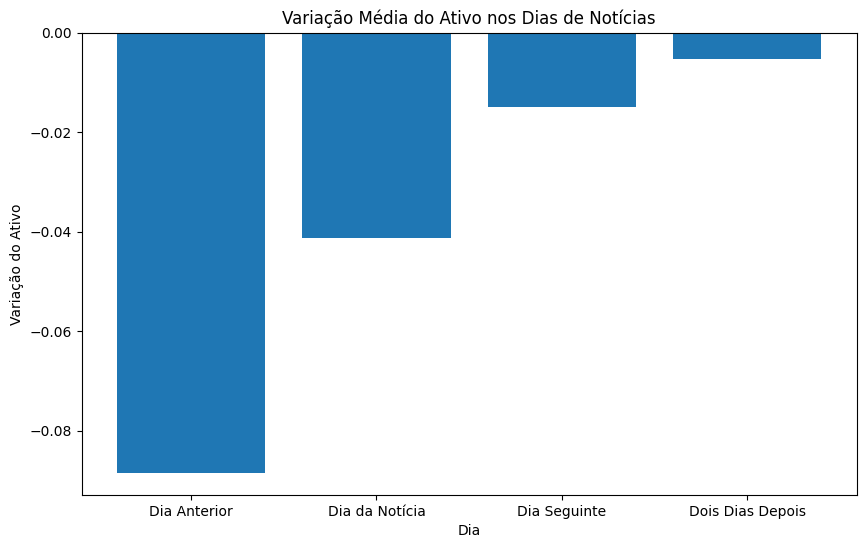

In [40]:
# Calcular a variação para cada dia
dados['var_dia_anterior'] = dados['fechamentoDiaAtual'] - dados['aberturaDiaAnterior']
dados['var_dia_da_noticia'] = dados['fechamentoDiaAtual'] - dados['aberturaDiaAtual']
dados['var_dia_seguinte'] = dados['fechamentoDiaSeguinte'] - dados['aberturaDiaSeguinte']
dados['var_dois_dias_depois'] = dados['fechamento2Dias'] - dados['abertura2Dias']

# Criar um gráfico de barras para mostrar as variações
plt.figure(figsize=(10, 6))
plt.bar(['Dia Anterior', 'Dia da Notícia', 'Dia Seguinte', 'Dois Dias Depois'],
        [dados['var_dia_anterior'].mean(), dados['var_dia_da_noticia'].mean(), dados['var_dia_seguinte'].mean(), dados['var_dois_dias_depois'].mean()])
plt.xlabel('Dia')
plt.ylabel('Variação do Ativo')
plt.title('Variação Média do Ativo nos Dias de Notícias')
plt.show()

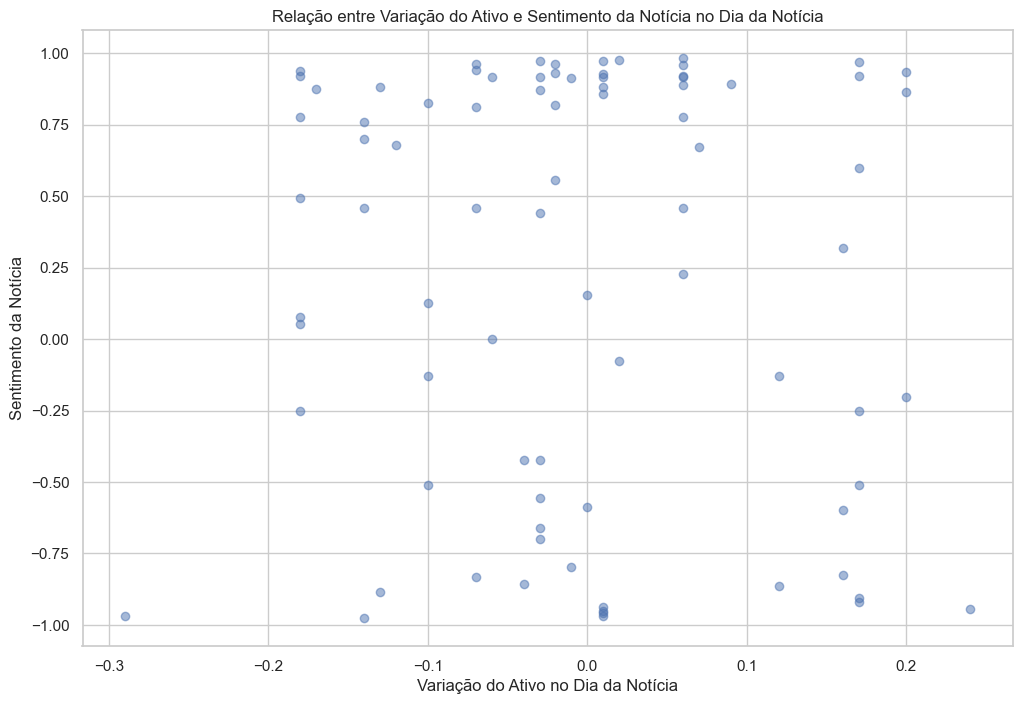

In [55]:
# Criar um gráfico de dispersão
plt.figure(figsize=(12, 8))

# Relacione a variação do ativo com o sentimento da notícia no dia da notícia
plt.scatter(dados['var_dois_dias_depois'], dados['sent_proc_3'], alpha=0.5)

plt.xlabel('Variação do Ativo no Dia da Notícia')
plt.ylabel('Sentimento da Notícia')
plt.title('Relação entre Variação do Ativo e Sentimento da Notícia no Dia da Notícia')
plt.grid(True)

plt.show()